In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression
import random
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

In [5]:
!ls ../input/keras-pretrained-models/

Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [6]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [7]:
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

In [8]:
!ls ~/.keras/models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [411]:
os.chdir("/kaggle/input/dog-breed-identification/")

In [420]:
df = pd.read_csv('labels.csv')
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
#     X[i] = cv2.resize(cv2.imread('train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:00<00:00, 81283.76it/s]


In [421]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [ ]:
# inception_features = get_features(InceptionV3, X)
# xception_features = get_features(Xception, X)
# features = np.concatenate([inception_features, xception_features], axis=-1)
# print(inception_features.shape,xception_features.shape)

In [408]:
features = np.load('../missing-dog/features.npy')
print(features.shape)

(10222, 4096)


In [422]:
features.shape,y.shape

((10222, 4096), (10222, 120))

In [423]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=50, validation_split=0.1)

Epoch 1/50
72/72 [==============================] - 0s 5ms/step - loss: 1.8791 - accuracy: 0.6076 - val_loss: 0.7048 - val_accuracy: 0.8240
Epoch 2/50
72/72 [==============================] - 0s 4ms/step - loss: 0.5778 - accuracy: 0.8415 - val_loss: 0.5410 - val_accuracy: 0.8436
Epoch 3/50
72/72 [==============================] - 0s 4ms/step - loss: 0.4429 - accuracy: 0.8739 - val_loss: 0.5286 - val_accuracy: 0.8299
Epoch 4/50
72/72 [==============================] - 0s 4ms/step - loss: 0.3602 - accuracy: 0.8935 - val_loss: 0.4758 - val_accuracy: 0.8436
Epoch 5/50
72/72 [==============================] - 0s 4ms/step - loss: 0.3016 - accuracy: 0.9151 - val_loss: 0.4626 - val_accuracy: 0.8514
Epoch 6/50
72/72 [==============================] - 0s 4ms/step - loss: 0.2596 - accuracy: 0.9296 - val_loss: 0.4606 - val_accuracy: 0.8495
Epoch 7/50
72/72 [==============================] - 0s 4ms/step - loss: 0.2258 - accuracy: 0.9405 - val_loss: 0.4486 - val_accuracy: 0.8612
Epoch 8/50
72/72 [==

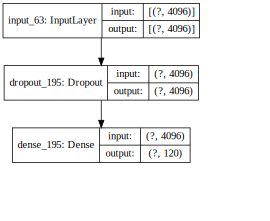

In [424]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [435]:
model.predict(features)[0]

array([4.53292657e-08, 6.26485919e-10, 1.82710214e-09, 1.78998649e-09,
       1.09688095e-07, 1.30017810e-07, 2.02497397e-08, 1.62538161e-08,
       6.71020961e-10, 7.28762259e-08, 6.48128529e-09, 1.54035662e-09,
       1.69764434e-08, 1.00231105e-07, 1.08126192e-08, 4.20441921e-08,
       1.16155681e-08, 2.67478129e-08, 1.31385178e-07, 2.41963422e-10,
       1.69684554e-07, 9.95927507e-11, 2.85436674e-10, 2.66054845e-09,
       4.37035164e-09, 1.49773438e-08, 1.98924202e-08, 8.10402501e-09,
       3.03155301e-09, 2.27164705e-08, 4.57377155e-06, 5.38746714e-10,
       4.27046443e-09, 4.51300464e-09, 2.46264653e-06, 2.09005746e-09,
       1.21086052e-09, 4.89015292e-07, 4.17991558e-10, 2.21512431e-09,
       6.12917539e-09, 6.08394557e-10, 2.48045229e-09, 3.67571507e-09,
       1.50994128e-09, 1.51043160e-08, 5.76388501e-08, 7.99387112e-10,
       2.67086602e-08, 4.05381240e-09, 1.68025760e-09, 6.86227908e-10,
       2.03830686e-09, 7.48722595e-09, 7.06263492e-09, 1.28249256e-09,
      

In [ ]:
###### import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# 유기견에 적용

In [443]:
os.chdir("/kaggle/input/missing-dog/")

In [13]:
df08_ = pd.read_csv('2019_08.csv')
df09_ = pd.read_csv('2019_08.csv')
df10_ = pd.read_csv('2019_10.csv')

In [44]:
df08 = df08_.drop([465,3784,5134,7429]) # size 0 : what happened?
df08.reset_index(inplace = True)

In [105]:
n = len(df08)
adoption_info = set(df08['breed'])
n_class = len(adoption_info)
class_to_num = dict(zip(adoption_info,range(n_class)))
width = 299
X1 = np.zeros((n, width, width, 3), dtype=np.uint8)
y1 = np.zeros((n, n_class), dtype=np.uint8)
print("X's shape:",X1.shape,"\ny's shape:",y1.shape)

X's shape: (7723, 299, 299, 3) 
y's shape: (7723, 16)


In [107]:
for i in tqdm(range(n)):
    #X[i] = cv2.resize(cv2.imread('2019_08/%s.jpg' % df08['notice_num'][i]), (width, width))
    y1[i][class_to_num[df08['breed'][i]]] = 1 # adoption label 뒤집힘

100%|██████████| 7723/7723 [00:00<00:00, 78789.60it/s]


In [17]:
df10 = df10_.drop([631,2093,2588,4301,5324,5325,5557,7082,7083,7084,7085]) # size 0 : what happened?
df10.reset_index(inplace = True)

In [133]:
n = len(df10)
adoption_info = set(df10['breed'])
n_class = len(adoption_info)
class_to_num = dict(zip(adoption_info,range(n_class)))
width = 299
X2 = np.zeros((n, width, width, 3), dtype=np.uint8)
y2 = np.zeros((n, n_class), dtype=np.uint8)
print("X2's shape:",X2.shape,"\ny2's shape:",y2.shape)

X2's shape: (7075, 299, 299, 3) 
y2's shape: (7075, 16)


In [135]:
for i in tqdm(range(n)):
    #X2[i] = cv2.resize(cv2.imread('2019_10/%s.jpg' % df10['notice_num'][i]), (width, width))
    y2[i][class_to_num[df10['breed'][i]]] = 1 # adoption label 뒤집힘

100%|██████████| 7075/7075 [00:00<00:00, 79731.26it/s]


In [359]:
X_dog = np.concatenate([X1, X2], axis=0)
y_dog = np.concatenate([y1, y2], axis=0)

In [ ]:
np.save('/kaggle/working/X.npy', X)
np.save('/kaggle/working/y.npy', y)
np.save('/kaggle/working/X2.npy', X2)
np.save('/kaggle/working/y2.npy', y2)

In [ ]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features1 = np.concatenate([inception_features, xception_features], axis=-1)
print(inception_features.shape,xception_features.shape,features1.shape)
inception_features2 = get_features(InceptionV3, X2)
xception_features2 = get_features(Xception, X2)
features2 = np.concatenate([inception_features2, xception_features2], axis=-1)
print(inception_features2.shape,xception_features2.shape,features2.shape)
# np.save('/kaggle/working/features1',features1)
# np.save('/kaggle/working/features2',features2)

In [444]:
features1 = np.load('../missing-dog/features1.npy')
features2 = np.load('../missing-dog/features2.npy')

In [445]:
features = np.concatenate([features1,features2],axis=0)
y_dog= np.concatenate([y1,y2],axis=0)

유기견 나의 세트로 학습

In [ ]:
# inputs = Input(features.shape[1:])
# x = inputs
# x = Dropout(0.2)(x)
# x = Dense(2, activation='softmax')(x)

# model = Model(inputs, x)
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# h = model.fit(features, y_dog, batch_size=128, epochs=100, validation_split=0.1)

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [ ]:
df08.head(5)

In [367]:
n = len(df08)
breed = set(df08['adoption_info'])
n_class = len(breed)
class_to_num = dict(zip(breed,range(n_class)))
width = 299
yk_1 = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    yk_1[i][class_to_num[df08['adoption_info'][i]]] = 1 # adoption label 뒤집힘

100%|██████████| 7723/7723 [00:00<00:00, 80740.51it/s]


In [368]:
n = len(df10)
breed = set(df10['adoption_info'])
n_class = len(breed)
class_to_num = dict(zip(breed,range(n_class)))
width = 299
yk_2 = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    yk_2[i][class_to_num[df10['adoption_info'][i]]] = 1 # adoption label 뒤집힘

100%|██████████| 7075/7075 [00:00<00:00, 80593.75it/s]


In [369]:
yk = np.concatenate([yk_1,yk_2],axis=0)

In [ ]:
X = np.zeros((n, width, width, 3), dtype=np.uint8)
yk = np.zeros((n, n_class), dtype=np.uint8)

In [ ]:
yk.shape

In [ ]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.8)(x)
x = Dense(512, activation='softmax')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=100, validation_split=0.2)

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [ ]:
df08.breed.value_counts()

In [ ]:
df08[['sex','weight','age']]

In [22]:
def txtfeature(df):
    n = len(df) 
    x_text = np.zeros((n, 4), dtype=np.uint8)

    for i in range(len(df)):
        if(df['sex'][i]==1):
            x_text[i][0]=1
        else:
            x_text[i][1]=1
        x_text[i][2]=df['weight'][i]
        x_text[i][3]=df['age'][i]
    
    return x_text

In [358]:
x1_text = txtfeature(df08[['sex','weight','age']])
x2_text = txtfeature(df10[['sex','weight','age']])

In [24]:
X_text = np.concatenate([x1_text,x2_text],axis=0)
newdf = pd.DataFrame(X_text)
normalized_df=(newdf[[2,3]]-newdf[[2,3]].mean())/newdf[[2,3]].std()

In [25]:
X_text = np.array(newdf)

In [26]:
X_text.shape

(14798, 4)

In [27]:
#df08['breed'].value_counts()
df10['breed'].value_counts()

2     5662
3      304
4      303
1      179
25     106
15      87
13      87
12      71
5       57
7       55
8       46
9       33
35      31
10      20
47      19
26      15
Name: breed, dtype: int64

# Nomix classification

In [72]:
df08_nomix = df08[df08['breed']!=2]
df10_nomix = df10[df10['breed']!=2]

In [75]:
df08_nomix['index']

11        11
12        12
13        13
14        14
15        15
        ... 
7712    7716
7716    7720
7718    7722
7719    7723
7721    7725
Name: index, Length: 1776, dtype: int64

In [262]:
set(df08_nomix['breed'])

{1, 3, 4, 5, 7, 8, 9, 10, 12, 13, 15, 25, 26, 35, 47}

In [263]:
set(df10_nomix['breed'])

{1, 3, 4, 5, 7, 8, 9, 10, 12, 13, 15, 25, 26, 35, 47}

In [238]:
def makedata(df_nomix,df_y,feature):
    n = len(df_nomix)
    breed = set(df_nomix['breed'])
    n_class = len(breed)
    class_to_num = dict(zip(breed,range(n_class)))
    Xmx = np.zeros((n,4096), dtype=np.float32)
    ymx = np.zeros((n, n_class+1), dtype=np.uint8)
    m = 0
    for i in list(df_nomix.index):
        Xmx[m] = feature[i]
        ymx[m] = df_y[i]
        m += 1
    ymx = np.delete(ymx,(1),axis=1)
    return Xmx,ymx

In [239]:
Xmx1,ymx1 = makedata(df08_nomix,y1,features1)
Xmx2,ymx2 = makedata(df10_nomix,y2,features2)

In [240]:
Xmx = np.concatenate([Xmx1,Xmx2],axis=0)
ymx = np.concatenate([ymx1,ymx2],axis=0)

In [260]:
ymx2[1]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [241]:
df10_nomix

,index,notice_num,breed,sex,weight,age,adoption_info
6,6,공고번호-경남-사천-2019-00927 분실된동물사진,3,2,5.00,1,0
7,7,공고번호-강원-원주-2019-01065 분실된동물사진,4,1,5.30,8,0
8,8,공고번호-강원-원주-2019-01064 분실된동물사진,3,1,3.10,6,0
9,9,공고번호-강원-원주-2019-01063 분실된동물사진,1,1,21.00,5,0
10,10,공고번호-서울-도봉-2019-00218 분실된동물사진,5,1,17.60,7,0
...,...,...,...,...,...,...,...
7065,7072,공고번호-울산-울주-2019-00570 분실된동물사진,25,1,2.00,1,1
7071,7078,공고번호-인천-서구-2019-01018 분실된동물사진,12,2,2.10,5,1
7072,7079,공고번호-대구-달성-2019-00857 분실된동물사진,1,2,3.25,1,0
7073,7080,공고번호-대구-서구-2019-00573 분실된동물사진,15,1,6.80,4,1


In [437]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)
x = Dropout(0.9)(x)
x = Dense(300, activation='sigmoid')(x)
x = BatchNormalization()(x)
x = Dropout(0.9)(x)
x = Dense(15, activation='softmax')(x)

model_my = Model(inputs, x)
model_my.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model_my.fit(Xmx, ymx, batch_size=128, epochs=200, validation_split=0.1)

Epoch 1/500
23/23 [==============================] - 0s 13ms/step - loss: 5.9929 - accuracy: 0.1530 - val_loss: 2.5318 - val_accuracy: 0.0219
Epoch 2/500
23/23 [==============================] - 0s 6ms/step - loss: 3.9109 - accuracy: 0.3380 - val_loss: 1.7709 - val_accuracy: 0.4295
Epoch 3/500
23/23 [==============================] - 0s 6ms/step - loss: 3.1632 - accuracy: 0.4373 - val_loss: 1.3459 - val_accuracy: 0.6458
Epoch 4/500
23/23 [==============================] - 0s 6ms/step - loss: 2.8151 - accuracy: 0.4913 - val_loss: 1.1457 - val_accuracy: 0.6928
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 2.3867 - accuracy: 0.5300 - val_loss: 1.0388 - val_accuracy: 0.6991
Epoch 6/500
23/23 [==============================] - 0s 6ms/step - loss: 2.2067 - accuracy: 0.5429 - val_loss: 0.9590 - val_accuracy: 0.7179
Epoch 7/500
23/23 [==============================] - 0s 6ms/step - loss: 2.0259 - accuracy: 0.5711 - val_loss: 0.9060 - val_accuracy: 0.7179
Epoch 8/500


Epoch 59/500
23/23 [==============================] - 0s 8ms/step - loss: 0.6943 - accuracy: 0.7857 - val_loss: 0.6378 - val_accuracy: 0.8245
Epoch 60/500
23/23 [==============================] - 0s 7ms/step - loss: 0.7109 - accuracy: 0.7770 - val_loss: 0.6347 - val_accuracy: 0.8245
Epoch 61/500
23/23 [==============================] - 0s 6ms/step - loss: 0.6849 - accuracy: 0.7840 - val_loss: 0.6316 - val_accuracy: 0.8150
Epoch 62/500
23/23 [==============================] - 0s 6ms/step - loss: 0.6838 - accuracy: 0.7889 - val_loss: 0.6337 - val_accuracy: 0.8182
Epoch 63/500
23/23 [==============================] - 0s 6ms/step - loss: 0.6569 - accuracy: 0.7937 - val_loss: 0.6321 - val_accuracy: 0.8150
Epoch 64/500
23/23 [==============================] - 0s 6ms/step - loss: 0.6528 - accuracy: 0.7976 - val_loss: 0.6262 - val_accuracy: 0.7994
Epoch 65/500
23/23 [==============================] - 0s 6ms/step - loss: 0.7062 - accuracy: 0.7801 - val_loss: 0.6180 - val_accuracy: 0.8119
Epoch 

23/23 [==============================] - 0s 5ms/step - loss: 0.5558 - accuracy: 0.8240 - val_loss: 0.6482 - val_accuracy: 0.8119
Epoch 117/500
23/23 [==============================] - 0s 5ms/step - loss: 0.5593 - accuracy: 0.8251 - val_loss: 0.6607 - val_accuracy: 0.8025
Epoch 118/500
23/23 [==============================] - 0s 5ms/step - loss: 0.5260 - accuracy: 0.8254 - val_loss: 0.6415 - val_accuracy: 0.8025
Epoch 119/500
23/23 [==============================] - 0s 5ms/step - loss: 0.5485 - accuracy: 0.8233 - val_loss: 0.6527 - val_accuracy: 0.8119
Epoch 120/500
23/23 [==============================] - 0s 5ms/step - loss: 0.5325 - accuracy: 0.8233 - val_loss: 0.6472 - val_accuracy: 0.8182
Epoch 121/500
23/23 [==============================] - 0s 6ms/step - loss: 0.5366 - accuracy: 0.8317 - val_loss: 0.6505 - val_accuracy: 0.8150
Epoch 122/500
23/23 [==============================] - 0s 6ms/step - loss: 0.5405 - accuracy: 0.8202 - val_loss: 0.6455 - val_accuracy: 0.8213
Epoch 123/500

23/23 [==============================] - 0s 6ms/step - loss: 0.4929 - accuracy: 0.8380 - val_loss: 0.6773 - val_accuracy: 0.8150
Epoch 174/500
23/23 [==============================] - 0s 5ms/step - loss: 0.5102 - accuracy: 0.8387 - val_loss: 0.7043 - val_accuracy: 0.8119
Epoch 175/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4660 - accuracy: 0.8547 - val_loss: 0.6881 - val_accuracy: 0.8150
Epoch 176/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4950 - accuracy: 0.8380 - val_loss: 0.6842 - val_accuracy: 0.8213
Epoch 177/500
23/23 [==============================] - 0s 8ms/step - loss: 0.4742 - accuracy: 0.8446 - val_loss: 0.6777 - val_accuracy: 0.8150
Epoch 178/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4407 - accuracy: 0.8505 - val_loss: 0.6965 - val_accuracy: 0.8150
Epoch 179/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4743 - accuracy: 0.8453 - val_loss: 0.7156 - val_accuracy: 0.8088
Epoch 180/500

23/23 [==============================] - 0s 5ms/step - loss: 0.4468 - accuracy: 0.8544 - val_loss: 0.6903 - val_accuracy: 0.8213
Epoch 231/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4405 - accuracy: 0.8495 - val_loss: 0.6885 - val_accuracy: 0.8150
Epoch 232/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4816 - accuracy: 0.8481 - val_loss: 0.6719 - val_accuracy: 0.8213
Epoch 233/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4197 - accuracy: 0.8578 - val_loss: 0.6739 - val_accuracy: 0.8182
Epoch 234/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4430 - accuracy: 0.8575 - val_loss: 0.6748 - val_accuracy: 0.8119
Epoch 235/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4454 - accuracy: 0.8596 - val_loss: 0.6854 - val_accuracy: 0.8245
Epoch 236/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4729 - accuracy: 0.8484 - val_loss: 0.6855 - val_accuracy: 0.8245
Epoch 237/500

23/23 [==============================] - 0s 7ms/step - loss: 0.4613 - accuracy: 0.8554 - val_loss: 0.6785 - val_accuracy: 0.8150
Epoch 288/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4467 - accuracy: 0.8589 - val_loss: 0.6782 - val_accuracy: 0.8119
Epoch 289/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4233 - accuracy: 0.8599 - val_loss: 0.6733 - val_accuracy: 0.8245
Epoch 290/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4215 - accuracy: 0.8620 - val_loss: 0.6607 - val_accuracy: 0.8276
Epoch 291/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4274 - accuracy: 0.8585 - val_loss: 0.6748 - val_accuracy: 0.8276
Epoch 292/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4314 - accuracy: 0.8603 - val_loss: 0.6766 - val_accuracy: 0.8182
Epoch 293/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4230 - accuracy: 0.8582 - val_loss: 0.6708 - val_accuracy: 0.8213
Epoch 294/500

23/23 [==============================] - 0s 5ms/step - loss: 0.4202 - accuracy: 0.8631 - val_loss: 0.7071 - val_accuracy: 0.8213
Epoch 345/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4502 - accuracy: 0.8519 - val_loss: 0.7250 - val_accuracy: 0.8245
Epoch 346/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4222 - accuracy: 0.8617 - val_loss: 0.7263 - val_accuracy: 0.8213
Epoch 347/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4192 - accuracy: 0.8690 - val_loss: 0.7110 - val_accuracy: 0.8182
Epoch 348/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4260 - accuracy: 0.8551 - val_loss: 0.7232 - val_accuracy: 0.8150
Epoch 349/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4170 - accuracy: 0.8676 - val_loss: 0.7018 - val_accuracy: 0.8307
Epoch 350/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4018 - accuracy: 0.8676 - val_loss: 0.7015 - val_accuracy: 0.8307
Epoch 351/500

23/23 [==============================] - 0s 5ms/step - loss: 0.3909 - accuracy: 0.8763 - val_loss: 0.7362 - val_accuracy: 0.8182
Epoch 402/500
23/23 [==============================] - 0s 5ms/step - loss: 0.3728 - accuracy: 0.8763 - val_loss: 0.7456 - val_accuracy: 0.8245
Epoch 403/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4255 - accuracy: 0.8603 - val_loss: 0.7292 - val_accuracy: 0.8182
Epoch 404/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4092 - accuracy: 0.8672 - val_loss: 0.7272 - val_accuracy: 0.8213
Epoch 405/500
23/23 [==============================] - 0s 5ms/step - loss: 0.3975 - accuracy: 0.8728 - val_loss: 0.7251 - val_accuracy: 0.8150
Epoch 406/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4044 - accuracy: 0.8707 - val_loss: 0.7327 - val_accuracy: 0.8182
Epoch 407/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4103 - accuracy: 0.8704 - val_loss: 0.7461 - val_accuracy: 0.8182
Epoch 408/500

23/23 [==============================] - 0s 6ms/step - loss: 0.3997 - accuracy: 0.8739 - val_loss: 0.7383 - val_accuracy: 0.8182
Epoch 459/500
23/23 [==============================] - 0s 6ms/step - loss: 0.3887 - accuracy: 0.8819 - val_loss: 0.7475 - val_accuracy: 0.8245
Epoch 460/500
23/23 [==============================] - 0s 5ms/step - loss: 0.3740 - accuracy: 0.8700 - val_loss: 0.7625 - val_accuracy: 0.8213
Epoch 461/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4132 - accuracy: 0.8672 - val_loss: 0.7338 - val_accuracy: 0.8245
Epoch 462/500
23/23 [==============================] - 0s 6ms/step - loss: 0.3772 - accuracy: 0.8711 - val_loss: 0.7469 - val_accuracy: 0.8150
Epoch 463/500
23/23 [==============================] - 0s 6ms/step - loss: 0.3781 - accuracy: 0.8739 - val_loss: 0.7511 - val_accuracy: 0.8245
Epoch 464/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4191 - accuracy: 0.8624 - val_loss: 0.6971 - val_accuracy: 0.8119
Epoch 465/500

Text(0.5, 0, 'epoch')

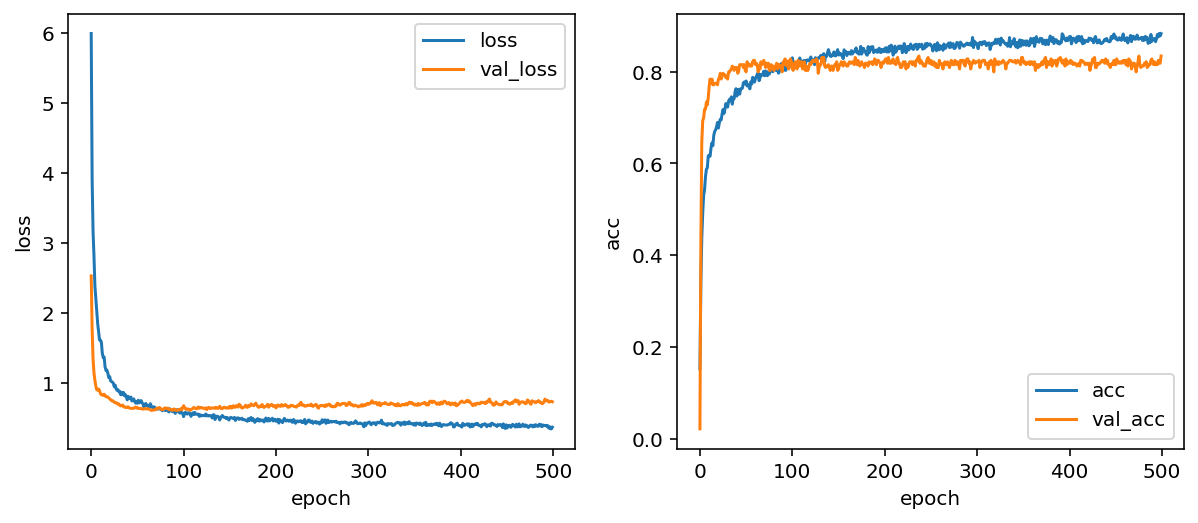

In [438]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [439]:
max(h.history['val_accuracy'])

0.8338558077812195

In [448]:
features.shape

(14798, 4096)

# multimodal model

In [356]:
from keras.layers.merge import concatenate

In [454]:
feature_whole = np.concatenate([model_my.predict(features),X_text],axis=1)

In [456]:
feature_whole.shape,yk.shape

((14798, 19), (14798, 2))

In [460]:
inputs = Input(feature_whole.shape[1:])
x = inputs
x = Dropout(0.6)(x)
x = Dense(60, activation='sigmoid')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(feature_whole, yk, batch_size=128, epochs=100, validation_split=0.1)

Epoch 1/100
105/105 [==============================] - 1s 5ms/step - loss: 0.9429 - accuracy: 0.5369 - val_loss: 0.6231 - val_accuracy: 0.7074
Epoch 2/100
105/105 [==============================] - 0s 3ms/step - loss: 0.7439 - accuracy: 0.6008 - val_loss: 0.6087 - val_accuracy: 0.7074
Epoch 3/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.6400 - val_loss: 0.6062 - val_accuracy: 0.7074
Epoch 4/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6631 - val_loss: 0.6042 - val_accuracy: 0.7074
Epoch 5/100
105/105 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6777 - val_loss: 0.6016 - val_accuracy: 0.7074
Epoch 6/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6809 - val_loss: 0.6037 - val_accuracy: 0.7074
Epoch 7/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6841 - val_loss: 0.5992 - val_accuracy: 0.7074

Epoch 58/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6859 - val_loss: 0.5902 - val_accuracy: 0.7074
Epoch 59/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6852 - val_loss: 0.5930 - val_accuracy: 0.7074
Epoch 60/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6869 - val_loss: 0.5913 - val_accuracy: 0.7074
Epoch 61/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.6848 - val_loss: 0.5924 - val_accuracy: 0.7074
Epoch 62/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6883 - val_loss: 0.5901 - val_accuracy: 0.7074
Epoch 63/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6852 - val_loss: 0.5932 - val_accuracy: 0.7074
Epoch 64/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6841 - val_loss: 0.5939 - val_accuracy:

Text(0.5, 0, 'epoch')

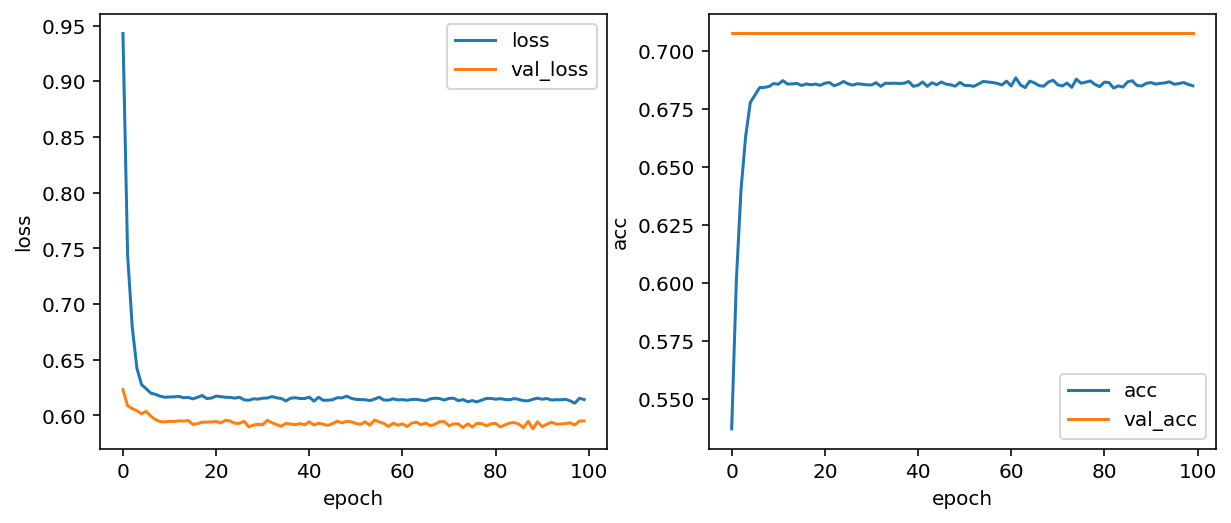

In [461]:
###### import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')